<a href="https://colab.research.google.com/github/Pisarenkova/KT_2025/blob/main/deepxde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepxde

  Using cached deepxde-1.13.2-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.9 MB/s eta 0:00:00


Compiling model...
Building feed-forward neural network...
'build' took 0.113594 s

'compile' took 1.829070 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [2.81e-01, 9.81e-01]    [2.81e-01, 9.81e-01]    [1.78e+00]    
1000      [2.53e-01, 3.21e-03]    [2.53e-01, 3.21e-03]    [3.39e-01]    

Best model at step 1000:
  train loss: 2.57e-01
  test loss: 2.57e-01
  test metric: [3.39e-01]

'train' took 42.214306 s

Training model...

Step      Train loss              Test loss               Test metric   
1000      [2.53e-01, 3.21e-03]    [2.53e-01, 3.21e-03]    [3.39e-01]    
2000      [2.52e-01, 1.34e-03]    [2.52e-01, 1.34e-03]    [3.27e-01]    

Best model at step 2000:
  train loss: 2.53e-01
  test loss: 2.53e-01
  test metric: [3.27e-01]

'train' took 38.611525 s

Training model...

Step      Train loss              Test loss               Test metric   
2000      [2.52e-01, 1.34e-03]    [2.52e-01, 1.34e-03]    [3.27e-01]    


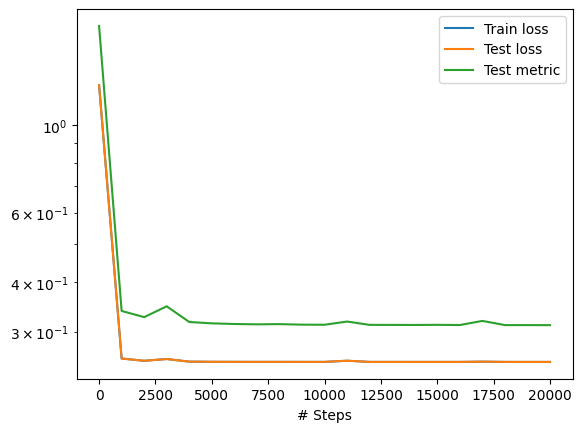

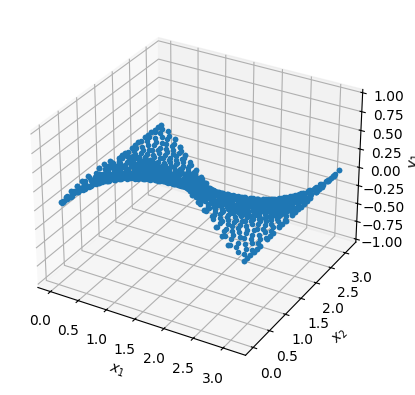

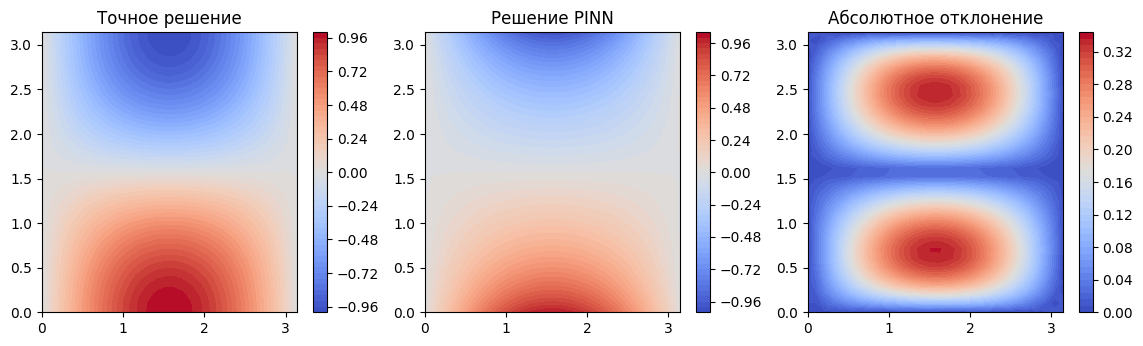

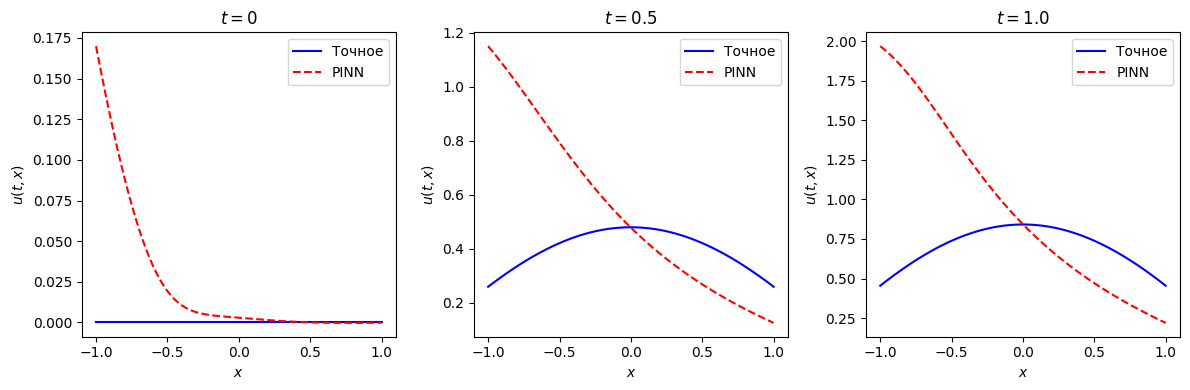

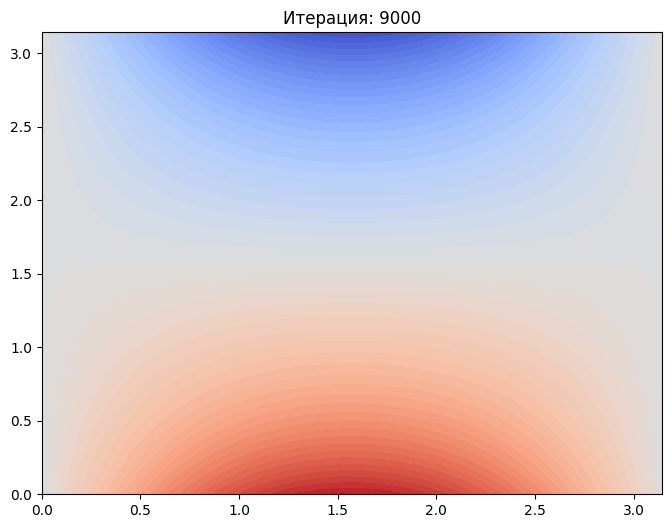

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from deepxde.backend import tf
import matplotlib.animation as animation

def domain():
    return dde.geometry.Rectangle(xmin=[0, 0], xmax=[np.pi, np.pi])

def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    return -dy_xx - dy_yy - f(x)

def boundary(x, on_boundary):
    return on_boundary

def exact_solution(x, k=1):
    return np.sin(k * x[:, 0]) * np.cos(x[:, 1])

def f(x):
    k = 1
    return -k**2 * tf.sin(k * x[:, 0]) * tf.cos(x[:, 1])

def g(x):
    return exact_solution(x).reshape(-1, 1)

geom = domain()
bc = dde.icbc.DirichletBC(geom, g, boundary)
data = dde.data.PDE(geom, pde, bc, num_domain=1000, num_boundary=100, solution=g)

layer_size = [2] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

predictions = []

model.compile("adam", lr=0.001, metrics=["l2 relative error"])

for i in range(10):
    model.train(iterations=1000)
    x = geom.uniform_points(1000, True)
    y_pred = model.predict(x)
    predictions.append(y_pred)

losshistory, train_state = model.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

def visualize_solution(model):
    x = geom.uniform_points(1000, True)
    y_exact = g(x)

    plt.figure(figsize=(14, 8))

    titles = ["Точное решение", "Решение PINN", "Абсолютное отклонение"]
    data = [y_exact.flatten(), predictions[-1].flatten(), np.abs(y_exact - predictions[-1]).flatten()]

    for i in range(3):
        plt.subplot(2, 3, i + 1)
        plt.tricontourf(x[:, 0], x[:, 1], data[i], levels=50, cmap="coolwarm")
        plt.colorbar()
        plt.title(titles[i])

    t_values = [0, 0.5, 1.0]
    x_slice = np.linspace(-1, 1, 100)

    plt.figure(figsize=(12, 4))

    for i, t in enumerate(t_values):
        x_test = np.column_stack((np.full_like(x_slice, t), x_slice))
        y_exact = exact_solution(x_test).flatten()
        y_pred = model.predict(x_test).flatten()

        plt.subplot(1, 3, i + 1)
        plt.plot(x_slice, y_exact, 'b-', label="Точное")
        plt.plot(x_slice, y_pred, 'r--', label="PINN")
        plt.xlabel(r"$x$")
        plt.ylabel(r"$u(t, x)$")
        plt.title(r"$t = {}$".format(t))
        plt.legend()

    plt.tight_layout()
    plt.show()

def animate_solution(predictions):
    fig, ax = plt.subplots(figsize=(8, 6))
    x = geom.uniform_points(1000, True)

    def update(frame):
        ax.clear()
        ax.tricontourf(x[:, 0], x[:, 1], predictions[frame].flatten(), levels=50, cmap="coolwarm")
        ax.set_title(f"Итерация: {frame * 1000}")

    ani = animation.FuncAnimation(fig, update, frames=len(predictions), repeat=False)
    ani.save('solution_animation.mp4', writer='ffmpeg', fps=2)

visualize_solution(model)
animate_solution(predictions)